# Ses Veriseti Analizi
Bu defter, √∂zellik √ßƒ±karƒ±mƒ±, k√ºmeleme, g√∂rselle≈ütirme ve basit bir sƒ±nƒ±flandƒ±rma modeli olu≈üturma dahil olmak √ºzere ESC-50 ses veriseti analiz s√ºrecini a√ßƒ±klamaktadƒ±r.

## 1. Gerekli K√ºt√ºphanelerin ƒ∞√ße Aktarƒ±lmasƒ±

In [76]:
import pandas as pd
import numpy as np
import librosa
import requests
import os
import pickle
from IPython.display import display
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D  # 3D √ßizim i√ßin gerekliv
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import hdbscan
import warnings

## 2. Dosyalarƒ± ƒ∞ndirme Fonksiyonu

In [13]:
# ESC-50 veri k√ºmesinin meta bilgilerini (CSV formatƒ±nda) i√ßeren dosyanƒ±n URL'si
CSV_URL = "https://raw.githubusercontent.com/karolpiczak/ESC-50/master/meta/esc50.csv"

# ESC-50 veri k√ºmesindeki ses dosyalarƒ±nƒ±n bulunduƒüu temel URL
AUDIO_BASE_URL = "https://github.com/karolpiczak/ESC-50/raw/master/audio/"

# ƒ∞nternetten bir dosyayƒ± indirip belirtilen isimle kaydeden fonksiyon
def download_file(url, filename):
    """Belirtilen URL'den dosyayƒ± indirir ve verilen dosya adƒ±na kaydeder."""
    
    # ƒ∞ndirme i≈üleminin ba≈üladƒ±ƒüƒ±nƒ± ekrana yazdƒ±r
    print(f"'{filename}' indiriliyor...")
    
    try:
        # URL'ye GET isteƒüi g√∂nder, veriyi par√ßa par√ßa (stream) indir
        response = requests.get(url, stream=True)
        
        # HTTP hatasƒ± varsa (404, 500 vb.) hata fƒ±rlat
        response.raise_for_status()
        
        # Dosyayƒ± ikili (binary) modda yazmak i√ßin a√ß
        with open(filename, 'wb') as f:
            # Veriyi 8192 baytlƒ±k par√ßalar halinde oku ve dosyaya yaz
            for chunk in response.iter_content(chunk_size=8192):
                f.write(chunk)
        
        # Ba≈üarƒ±lƒ± indirme mesajƒ± yazdƒ±r
        print(f"'{filename}' ba≈üarƒ±yla indirildi.")
    
    except requests.exceptions.RequestException as e:
        # ƒ∞ndirme sƒ±rasƒ±nda hata olu≈üursa ekrana yazdƒ±r
        print(f"Hata olu≈ütu: '{filename}' indirilemedi. {e}")
        
        # Ba≈üarƒ±sƒ±z indirme i√ßin False d√∂nd√ºr
        return False
    
    # Ba≈üarƒ±lƒ± indirme i√ßin True d√∂nd√ºr
    return True


## 3. CSV Dosyasƒ±nƒ± ƒ∞ndirme ve Verileri Y√ºkleme

In [14]:
# ƒ∞ndirilecek veya okunacak CSV dosyasƒ±nƒ±n yerel (local) adƒ±
csv_filename = "esc50.csv"

# Eƒüer CSV dosyasƒ± mevcut deƒüilse, URL'den indir
if not os.path.exists(csv_filename):
    download_file(CSV_URL, csv_filename)

# CSV dosyasƒ±nƒ± pandas DataFrame olarak oku
df = pd.read_csv(csv_filename)


'esc50.csv' indiriliyor...
'esc50.csv' ba≈üarƒ±yla indirildi.


In [15]:
# ƒ∞≈ülenecek maksimum ses dosyasƒ± sayƒ±sƒ±
limit = 2000  

# DataFrame'deki 'filename' s√ºtununu listeye √ßevir (ses dosyalarƒ±nƒ±n adlarƒ±)
audio_files = df['filename'].tolist()  

# "audio" klas√∂r√º yoksa olu≈ütur
if not os.path.exists("audio"):
    os.makedirs("audio")


## 4. Ses Dosyalarƒ±nƒ± ƒ∞ndirme ve √ñzellik √áƒ±karma

In [16]:
# √ñzellikleri (features) saklamak i√ßin bo≈ü listeler olu≈ütur
mfcc_features = []               # MFCC √∂zellikleri
chroma_features = []             # Chroma √∂zellikleri
spectral_contrast_features = []  # Spektral kontrast √∂zellikleri
file_names = []                  # Dosya adlarƒ±
labels = []                      # Sƒ±nƒ±flandƒ±rma etiketleri

# ƒ∞≈ülem ba≈üladƒ±ƒüƒ±nƒ± ekrana yazdƒ±r
print("\nSes dosyalarƒ± i≈üleniyor...")

# T√ºm ses dosyalarƒ± √ºzerinde d√∂ng√º
for audio_file in audio_files:
    # Ses dosyasƒ±nƒ±n yerel yolunu olu≈ütur
    audio_path = os.path.join("audio", audio_file)
    
    # Dosya yoksa URL'den indir
    if not os.path.exists(audio_path):
        download_file(AUDIO_BASE_URL + audio_file, audio_path)
    
    try:
        # Ses dosyasƒ±nƒ± y√ºkle (y: ses verisi, sr: √∂rnekleme oranƒ±)
        y, sr = librosa.load(audio_path)
        
        # MFCC (Mel-Frekans Kepstrum Katsayƒ±larƒ±) √ßƒ±kar
        mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
        mfccs_mean = np.mean(mfccs.T, axis=0)  # Zaman boyutu √ºzerinde ortalama
        mfcc_features.append(mfccs_mean)       # Listeye ekle
        
        # Chroma √∂zelliklerini √ßƒ±kar
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        chroma_mean = np.mean(chroma.T, axis=0)
        chroma_features.append(chroma_mean)
        
        # Spektral kontrast √∂zelliklerini √ßƒ±kar
        spectral_contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        spectral_contrast_mean = np.mean(spectral_contrast.T, axis=0)
        spectral_contrast_features.append(spectral_contrast_mean)
        
        # Dosya adƒ±nƒ± ve kategorisini ekle
        file_names.append(audio_file)
        labels.append(df[df['filename'] == audio_file]['category'].iloc[0])
        
        # Ba≈üarƒ±lƒ± √ßƒ±karƒ±m mesajƒ± yazdƒ±r
        print(f"'{audio_file}' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.")
    
    except Exception as e:
        # Hata durumunda mesaj yazdƒ±r
        print(f"Hata olu≈ütu: '{audio_file}' i≈ülenemedi. {e}")



Ses dosyalarƒ± i≈üleniyor...
'audio\1-100032-A-0.wav' indiriliyor...
'audio\1-100032-A-0.wav' ba≈üarƒ±yla indirildi.
'1-100032-A-0.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-100038-A-14.wav' indiriliyor...
'audio\1-100038-A-14.wav' ba≈üarƒ±yla indirildi.
'1-100038-A-14.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-100210-A-36.wav' indiriliyor...
'audio\1-100210-A-36.wav' ba≈üarƒ±yla indirildi.
'1-100210-A-36.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-100210-B-36.wav' indiriliyor...
'audio\1-100210-B-36.wav' ba≈üarƒ±yla indirildi.
'1-100210-B-36.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-101296-A-19.wav' indiriliyor...
'audio\1-101296-A-19.wav' ba≈üarƒ±yla indirildi.
'1-101296-A-19.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-101296-B-19.wav' indiriliyor...
'audio\1-101296-B-19.wav' ba≈üarƒ±yla indirildi.
'1-101296-B-19.wav' i√ßin MFCC, Chroma ve Spectral Contras

C:\Users\somef\AppData\Local\Temp\ipykernel_1776\2076890326.py:15: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(audio_path)
D:\Users\somef\anaconda3\Lib\site-packages\librosa\core\audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


'audio\1-16746-A-15.wav' ba≈üarƒ±yla indirildi.
'1-16746-A-15.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-17092-A-27.wav' indiriliyor...
'audio\1-17092-A-27.wav' ba≈üarƒ±yla indirildi.
'1-17092-A-27.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-17092-B-27.wav' indiriliyor...
'audio\1-17092-B-27.wav' ba≈üarƒ±yla indirildi.
'1-17092-B-27.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-17124-A-43.wav' indiriliyor...
'audio\1-17124-A-43.wav' ba≈üarƒ±yla indirildi.
'1-17124-A-43.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-17150-A-12.wav' indiriliyor...
'audio\1-17150-A-12.wav' ba≈üarƒ±yla indirildi.
'1-17150-A-12.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-172649-A-40.wav' indiriliyor...
'audio\1-172649-A-40.wav' ba≈üarƒ±yla indirildi.
'1-172649-A-40.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-172649-B-40.wav' indiriliyor...
'audio\1-172649-B-40.wav

D:\Users\somef\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


'audio\1-21934-A-38.wav' ba≈üarƒ±yla indirildi.
'1-21934-A-38.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-21935-A-38.wav' indiriliyor...
'audio\1-21935-A-38.wav' ba≈üarƒ±yla indirildi.
'1-21935-A-38.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-223162-A-25.wav' indiriliyor...
'audio\1-223162-A-25.wav' ba≈üarƒ±yla indirildi.
'1-223162-A-25.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-22694-A-20.wav' indiriliyor...
'audio\1-22694-A-20.wav' ba≈üarƒ±yla indirildi.
'1-22694-A-20.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-22694-B-20.wav' indiriliyor...
'audio\1-22694-B-20.wav' ba≈üarƒ±yla indirildi.
'1-22694-B-20.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-22804-A-46.wav' indiriliyor...
'audio\1-22804-A-46.wav' ba≈üarƒ±yla indirildi.
'1-22804-A-46.wav' i√ßin MFCC, Chroma ve Spectral Contrast √ßƒ±karƒ±ldƒ±.
'audio\1-22882-A-44.wav' indiriliyor...
'audio\1-22882-A-44.wav' 

In [17]:
# MFCC √∂zellik listesini NumPy dizisine √ßevir
X_mfcc = np.array(mfcc_features)

# Chroma √∂zellik listesini NumPy dizisine √ßevir
X_chroma = np.array(chroma_features)

# Spektral kontrast √∂zellik listesini NumPy dizisine √ßevir
X_spectral_contrast = np.array(spectral_contrast_features)

# T√ºm √∂zellikleri yatay olarak birle≈ütir (tek bir √∂zellik matrisi X olu≈ütur)
X = np.hstack((X_mfcc, X_chroma, X_spectral_contrast))

# Etiketleri (kategori isimleri) sayƒ±sal deƒüerlere d√∂n√º≈üt√ºrmek i√ßin LabelEncoder kullan
le = LabelEncoder()

# Etiketleri (y) sayƒ±sal deƒüerlere d√∂n√º≈üt√ºr
y = le.fit_transform(labels)


In [46]:
# H√ºcre 2: √ñzellik s√ºtun isimlerini olu≈ütur

# 13 adet MFCC s√ºtun ismi olu≈ütur: MFCC_1, MFCC_2, ... MFCC_13
feature_columns = [f'MFCC_{i+1}' for i in range(13)] + \
                  
                  # 12 adet Chroma s√ºtun ismi olu≈ütur: Chroma_1, ... Chroma_12
                  [f'Chroma_{i+1}' for i in range(12)] + \
                  
                  # 7 adet Spektral Kontrast s√ºtun ismi olu≈ütur: SpectralContrast_1, ... SpectralContrast_7
                  [f'SpectralContrast_{i+1}' for i in range(7)]


In [47]:
# H√ºcre 3: √ñzelliklerle birlikte DataFrame olu≈ütur

# √ñzellik matrisinden (X) ve s√ºtun isimlerinden (feature_columns) bir DataFrame olu≈ütur
df_features = pd.DataFrame(X, columns=feature_columns)

# Ses dosyalarƒ±nƒ±n adlarƒ±nƒ± DataFrame'e ekle
df_features['dosya_adi'] = file_names

# Kategorilerin (etiketlerin) orijinal metin hallerini ekle
df_features['kategori'] = labels

# Kategorilerin sayƒ±sal kodlanmƒ±≈ü hallerini ekle
df_features['kategori_kodlu'] = y


In [48]:
print("="*80)
# Ba≈ülƒ±k: Veri hakkƒ±nda genel bilgiler
print("üìä Veri Hakkƒ±nda Genel Bilgiler")
# Tekrar "=" √ßizgisi
print("="*80)
# DataFrame'deki toplam ses dosyasƒ± sayƒ±sƒ±nƒ± yazdƒ±r
print(f"Ses dosyasƒ± sayƒ±sƒ±: {len(df_features)}")
# Toplam √∂zellik (feature) sayƒ±sƒ±nƒ± yazdƒ±r
print(f"√ñzellik sayƒ±sƒ±: {len(feature_columns)}")
# Toplam sƒ±nƒ±f (kategori) sayƒ±sƒ±nƒ± yazdƒ±r
print(f"Sƒ±nƒ±f sayƒ±sƒ±: {len(np.unique(y))}")

üìä Veri Hakkƒ±nda Genel Bilgiler
Ses dosyasƒ± sayƒ±sƒ±: 1990
√ñzellik sayƒ±sƒ±: 32
Sƒ±nƒ±f sayƒ±sƒ±: 50


In [49]:

print("="*80)
# Ba≈ülƒ±k: Mevcut kategoriler
print("üìÇ Mevcut Kategoriler")
# Tekrar "=" √ßizgisi
print("="*80)
# 'kategori' s√ºtunundaki her kategorinin ka√ß kez ge√ßtiƒüini say ve yazdƒ±r
print(df_features['kategori'].value_counts())

üìÇ Mevcut Kategoriler
kategori
11    107
31     85
1      82
43     78
0      77
2      72
19     71
12     71
40     66
49     65
7      63
8      62
27     62
39     56
5      53
47     52
25     51
6      50
30     46
10     45
37     44
23     42
13     41
17     41
14     40
36     37
20     37
18     37
16     36
34     35
44     33
41     29
22     24
15     22
24     21
29     16
28     16
26     16
9      16
42     16
3      15
48     14
21     11
4      11
32     10
35      9
46      3
38      2
33      1
45      1
Name: count, dtype: int64


In [50]:
# G√∂rsel ayrƒ±m i√ßin 80 karakter uzunluƒüunda "=" i≈üareti yazdƒ±r
print("="*80)
# Ba≈ülƒ±k: ƒ∞lk 10 dosya
print("üîç ƒ∞lk 10 Dosya")
# Tekrar "=" √ßizgisi
print("="*80)
# Eƒüer display() fonksiyonu mevcutsa (√∂r. Jupyter Notebook ortamƒ±nda), DataFrame'i daha g√ºzel g√∂ster
if display:
    display(df_features[['dosya_adi', 'kategori', 'MFCC_1', 'Chroma_1', 'SpectralContrast_1']].head(10))
else:
    # Eƒüer display() yoksa, verileri normal print ile yazdƒ±r
    print(df_features[['dosya_adi', 'kategori', 'MFCC_1', 'Chroma_1', 'SpectralContrast_1']].head(10))

üîç ƒ∞lk 10 Dosya


dosya_adi  kategori      MFCC_1  Chroma_1  SpectralContrast_1
0   1-100032-A-0.wav        47 -600.940186  0.042679           14.326380
1  1-100038-A-14.wav        24 -193.978195  0.196118           19.399698
2  1-100210-A-36.wav        29   16.259266  0.159135           15.198257
3  1-100210-B-36.wav        29   17.771097  0.143590           14.297561
4  1-101296-A-19.wav        16 -423.075226  0.592749           19.576451
5  1-101296-B-19.wav        16 -399.657562  0.547045           19.737973
6  1-101336-A-30.wav         0 -434.757202  0.369623           14.735009
7  1-101404-A-34.wav        31 -488.842316  0.729320           16.006386
8   1-103298-A-9.wav        43 -118.723053  0.545701           12.756604
9  1-103995-A-30.wav        12 -568.592163  0.158304           13.444657

In [51]:
# G√∂rsel ayrƒ±m i√ßin 80 karakter uzunluƒüunda "=" i≈üareti yazdƒ±r
print("="*80)
# Ba≈ülƒ±k: √ñzellik istatistikleri
print("üìà √ñzellik ƒ∞statistikleri")
# Tekrar "=" √ßizgisi
print("="*80)
# Eƒüer display() fonksiyonu varsa (√∂r. Jupyter Notebook'ta), istatistikleri tablo ≈üeklinde g√∂ster
if display:
    display(df_features[feature_columns].describe().round(3))
else:
    # display() yoksa, istatistikleri konsola yazdƒ±r
    print(df_features[feature_columns].describe().round(3))

üìà √ñzellik ƒ∞statistikleri


MFCC_1    MFCC_2    MFCC_3    MFCC_4    MFCC_5    MFCC_6    MFCC_7  \
count  1990.000  1990.000  1990.000  1990.000  1990.000  1990.000  1990.000   
mean   -295.313    76.096   -13.268    10.542    -2.314     5.273    -1.879   
std     172.910    55.727    32.141    19.675    16.026    12.944    12.081   
min    -823.460  -152.223  -166.993   -62.389   -88.316   -48.047   -83.483   
25%    -418.709    36.469   -31.118     0.312   -10.928    -1.999    -8.425   
50%    -286.498    72.709    -9.832    10.304    -1.314     4.769    -1.083   
75%    -165.787   111.101     5.237    22.500     7.153    13.240     4.889   
max     117.617   284.340    98.824   116.087   109.281    69.392    45.512   

         MFCC_8    MFCC_9   MFCC_10  ...  Chroma_10  Chroma_11  Chroma_12  \
count  1990.000  1990.000  1990.000  ...   1990.000   1990.000   1990.000   
mean      3.426    -1.253     2.593  ...      0.436      0.434      0.444   
std      10.726     9.692     8.359  ...      0.201      0.200      0.205   
min     -48.351   -43.266   -33.741  ...      0.000      0.001      0.000   
25%      -2.283    -6.533    -2.059  ...      0.280      0.280      0.292   
50%       3.032    -0.824     2.526  ...      0.448      0.449      0.457   
75%       8.951     4.025     7.334  ...      0.593      0.591      0.604   
max      60.966    49.112    47.169  ...      0.999      1.000      1.000   

       SpectralContrast_1  SpectralContrast_2  SpectralContrast_3  \
count            1990.000            1990.000            1990.000   
mean               16.851              12.767              15.181   
std                 3.821               2.712               3.362   
min                 5.603               4.633               5.213   
25%                13.990              10.962              12.937   
50%                16.353              12.045              14.229   
75%                19.109              13.768              16.516   
max                37.513              30.781              32.726   

       SpectralContrast_4  SpectralContrast_5  SpectralContrast_6  \
count            1990.000            1990.000            1990.000   
mean               15.816              17.230              17.465   
std                 3.505               3.780               3.911   
min                 5.652               7.192               7.208   
25%                13.637              14.841              15.042   
50%                14.846              16.266              16.383   
75%                16.882              18.765              19.053   
max                39.783              47.537              40.914   

       SpectralContrast_7  
count            1990.000  
mean               43.829  
std                 8.110  
min                12.103  
25%                43.728  
50%                45.642  
75%                47.937  
max                72.321  

[8 rows x 32 columns]

## 5. K√ºmeleme Algoritmalarƒ±nƒ±n Uygulanmasƒ± (K-Means, DBSCAN, GMM)

üîß Veriyi iyile≈ütiriliyor...
‚úÖ Veriye StandardScaler uygulandƒ±
‚úÖ PCA: 32 ‚Üí 21 boyut (95.5% varyans a√ßƒ±klanƒ±yor)

üîç K-Means ile en uygun k√ºme sayƒ±sƒ± aranƒ±yor...
K=10: Silhouette Skoru = 0.117
K=20: Silhouette Skoru = 0.079
K=30: Silhouette Skoru = 0.075
K=40: Silhouette Skoru = 0.080
K=50: Silhouette Skoru = 0.066
‚úÖ En iyi k√ºme sayƒ±sƒ±: K=10 (Skor: 0.117)

üéØ GMM uygulanƒ±yor (K=10)...
GMM Silhouette Skoru: 0.028

üîß HDBSCAN parametreleri iyile≈ütiriliyor...
Yapƒ±landƒ±rma {'min_cluster_size': 10, 'min_samples': 5}: 2 k√ºme, 1594 g√ºr√ºlt√º - Reddedildi (k√ºme az veya g√ºr√ºlt√º fazla)
Yapƒ±landƒ±rma {'min_cluster_size': 15, 'min_samples': 10}: 2 k√ºme, 1574 g√ºr√ºlt√º - Skor: 0.580
Yapƒ±landƒ±rma {'min_cluster_size': 20, 'min_samples': 15}: 2 k√ºme, 1631 g√ºr√ºlt√º - Reddedildi (k√ºme az veya g√ºr√ºlt√º fazla)
Yapƒ±landƒ±rma {'min_cluster_size': 25, 'min_samples': 20}: 2 k√ºme, 1610 g√ºr√ºlt√º - Reddedildi (k√ºme az veya g√ºr√ºlt√º fazla)
‚úÖ En iyi HDBSCAN:

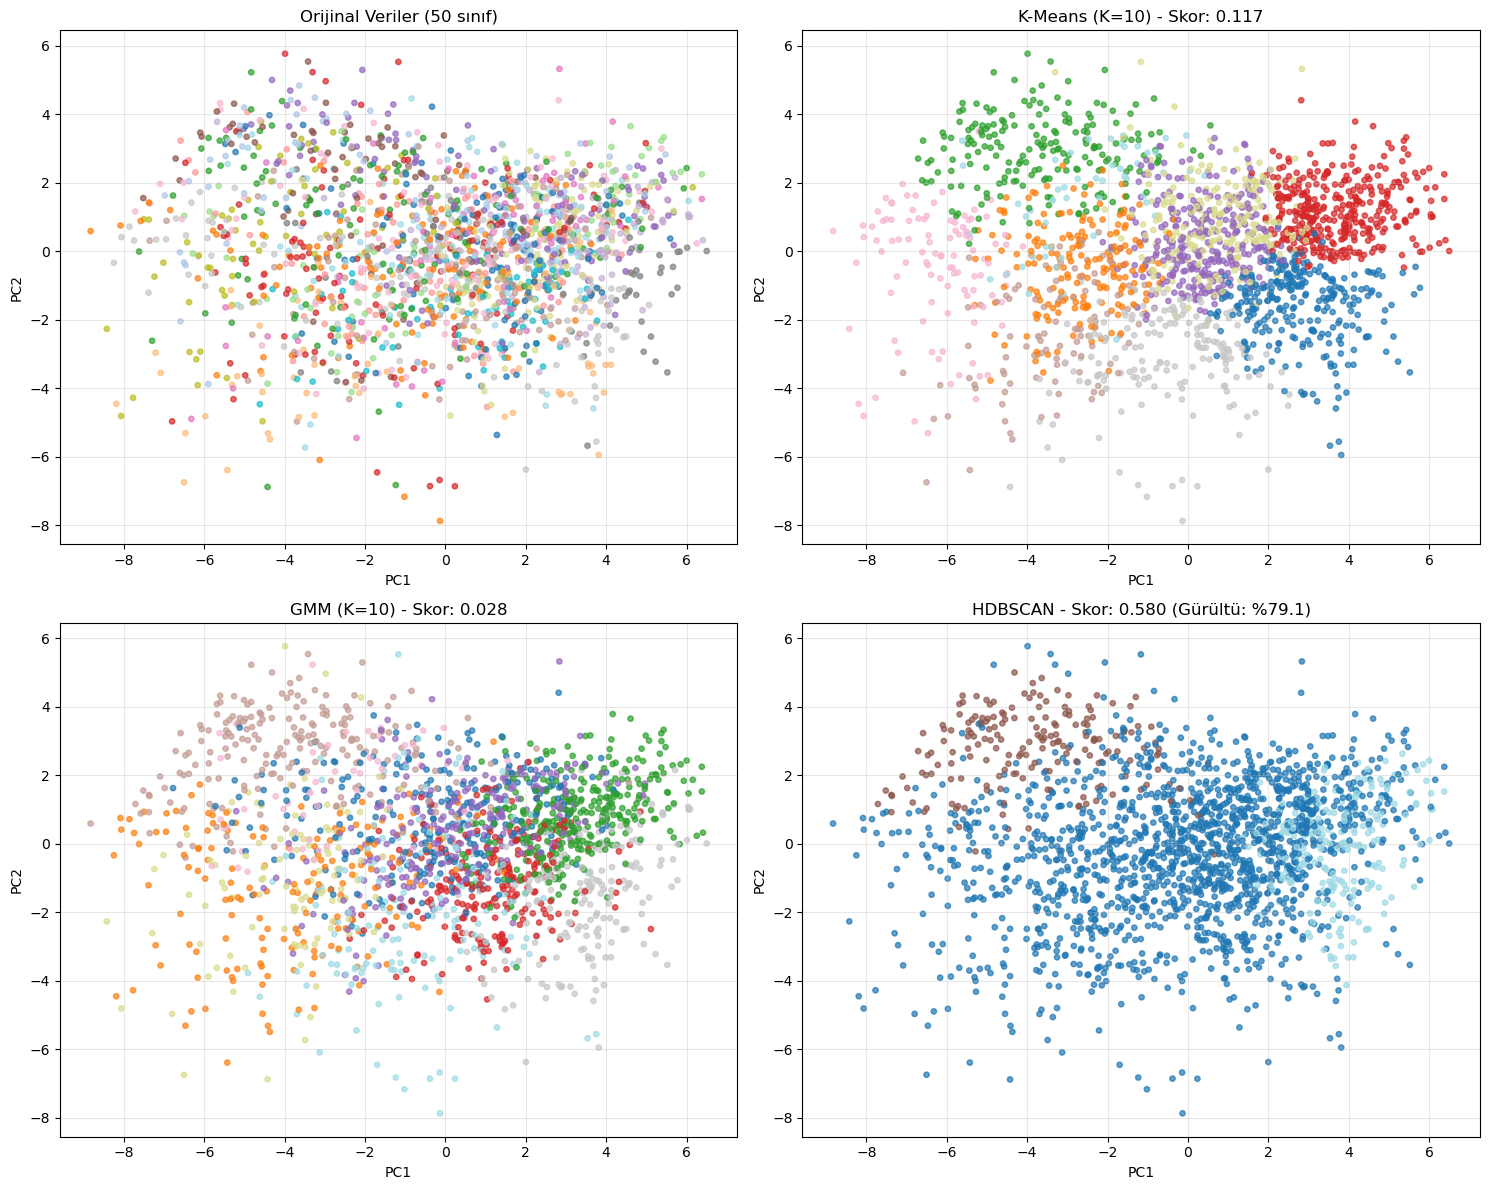


üèÜ Nihai Rapor - K√ºmeleme Sonu√ßlarƒ±
K-Means (K=10): 0.117
GMM (K=10): 0.028
HDBSCAN: 0.580

 En iyi y√∂ntem: HDBSCAN (Skor: 0.580)


In [54]:
# FutureWarning uyarƒ±larƒ±nƒ± gizle
warnings.filterwarnings("ignore", category=FutureWarning)

# Verilerin (X) mevcut olup olmadƒ±ƒüƒ±nƒ± kontrol et
if 'X' not in locals():
    print("‚ùå L√ºtfen √∂nce veri i≈üleme kodunu √ßalƒ±≈ütƒ±rƒ±n!")
else:
    print("üîß Veriler iyile≈ütiriliyor...")

    # 1Ô∏è‚É£ StandardScaler ile √∂zellikleri standartla≈ütƒ±r (ortalama=0, std=1)
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    print("‚úÖ StandardScaler uygulandƒ±")
    
    # 2Ô∏è‚É£ PCA ile boyut azaltma (%95 varyansƒ± koruyacak ≈üekilde)
    pca = PCA(n_components=0.95, random_state=0)
    X_pca = pca.fit_transform(X_scaled)
    print(f"‚úÖ PCA: {X.shape[1]} boyuttan {X_pca.shape[1]} boyuta d√º≈ü√ºr√ºld√º ({pca.explained_variance_ratio_.sum():.1%} varyans)")

    # 3Ô∏è‚É£ K-Means ile farklƒ± k√ºme sayƒ±larƒ±nda deneme yap ve Silhouette Score ile en iyisini bul
    print("\nüîç K-Means i√ßin en iyi k√ºme sayƒ±sƒ±nƒ± arƒ±yor...")
    K_range = [10, 20, 30, 40, 50]  # Denenecek k√ºme sayƒ±larƒ±
    silhouette_scores = []

    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
        labels = kmeans.fit_predict(X_pca)
        score = silhouette_score(X_pca, labels)
        silhouette_scores.append(score)
        print(f"K={k}: Silhouette Score = {score:.3f}")

    # En iyi K deƒüerini bul
    best_k = K_range[np.argmax(silhouette_scores)]
    best_score = max(silhouette_scores)
    print(f"‚úÖ En iyi k√ºme sayƒ±sƒ±: K={best_k} (Skor: {best_score:.3f})")

    # 4Ô∏è‚É£ Gaussian Mixture Model (GMM) ile aynƒ± K deƒüeriyle deneme
    print(f"\nüéØ GMM uygulanƒ±yor (K={best_k})...")
    gmm = GaussianMixture(n_components=best_k, random_state=0, max_iter=300)
    clusters_gmm = gmm.fit_predict(X_pca)

    # Skor hesaplama
    if len(np.unique(clusters_gmm)) > 1:
        score_gmm = silhouette_score(X_pca, clusters_gmm)
        print(f"GMM Silhouette Score: {score_gmm:.3f}")
    else:
        score_gmm = None
        print("GMM: Birden fazla k√ºme bulunamadƒ±")

    # 5Ô∏è‚É£ HDBSCAN i√ßin farklƒ± parametreler dene
    print("\nüîß HDBSCAN parametreleri deneniyor...")
    hdbscan_configs = [
        {"min_cluster_size": 10, "min_samples": 5},
        {"min_cluster_size": 15, "min_samples": 10},
        {"min_cluster_size": 20, "min_samples": 15},
        {"min_cluster_size": 25, "min_samples": 20}
    ]

    best_hdbscan_score = -1
    best_hdbscan_clusters = None
    best_hdbscan_config = None

    for config in hdbscan_configs:
        clusterer = hdbscan.HDBSCAN(**config)
        clusters = clusterer.fit_predict(X_pca)

        noise_count = np.sum(clusters == -1)  # G√ºr√ºlt√º olarak etiketlenen nokta sayƒ±sƒ±
        unique_clusters = len(np.unique(clusters[clusters != -1]))  # Ger√ßek k√ºme sayƒ±sƒ±

        print(f"Ayar {config}: {unique_clusters} k√ºme, {noise_count} g√ºr√ºlt√º", end="")

        if unique_clusters > 1 and noise_count < len(clusters) * 0.8:
            mask = clusters != -1
            if np.sum(mask) > 10:
                score = silhouette_score(X_pca[mask], clusters[mask])
                print(f" - Skor: {score:.3f}")

                if score > best_hdbscan_score:
                    best_hdbscan_score = score
                    best_hdbscan_clusters = clusters
                    best_hdbscan_config = config
            else:
                print(" - √áok az veri kaldƒ±")
        else:
            print(" - Reddedildi (k√ºme sayƒ±sƒ± az veya g√ºr√ºlt√º oranƒ± y√ºksek)")

    # En iyi HDBSCAN sonucunu kaydet
    if best_hdbscan_clusters is not None:
        print(f"‚úÖ En iyi HDBSCAN ayarƒ±: {best_hdbscan_config}, Skor: {best_hdbscan_score:.3f}")
        clusters_hdbscan = best_hdbscan_clusters
        score_hdbscan = best_hdbscan_score
    else:
        print("‚ùå HDBSCAN iyi sonu√ß vermedi")
        clusters_hdbscan = None
        score_hdbscan = None

    # 6Ô∏è‚É£ G√∂rselle≈ütirme
    print("\nüìä Grafikler olu≈üturuluyor...")
    pca_2d = PCA(n_components=2, random_state=0)
    X_pca_2d = pca_2d.fit_transform(X_scaled)

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # Orijinal veriler (etiketler varsa)
    if 'y' in locals():
        axes[0,0].scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=y, cmap='tab20', s=15, alpha=0.7)
        axes[0,0].set_title(f'Orijinal Veri ({len(np.unique(y))} sƒ±nƒ±f)')
    else:
        axes[0,0].text(0.5, 0.5, 'Etiket yok', ha='center', va='center', fontsize=14)
        axes[0,0].set_title('Orijinal Veri')

    # K-Means
    kmeans_best = KMeans(n_clusters=best_k, random_state=0, n_init=10)
    kmeans_clusters = kmeans_best.fit_predict(X_pca)
    axes[0,1].scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=kmeans_clusters, cmap='tab20', s=15, alpha=0.7)
    axes[0,1].set_title(f'K-Means (K={best_k}) - Skor: {best_score:.3f}')

    # GMM
    if clusters_gmm is not None and score_gmm is not None:
        axes[1,0].scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=clusters_gmm, cmap='tab20', s=15, alpha=0.7)
        axes[1,0].set_title(f'GMM (K={best_k}) - Skor: {score_gmm:.3f}')
    else:
        axes[1,0].text(0.5, 0.5, 'GMM ba≈üarƒ±sƒ±z', ha='center', va='center', fontsize=14)
        axes[1,0].set_title('GMM - Ba≈üarƒ±sƒ±z')

    # HDBSCAN
    if clusters_hdbscan is not None and score_hdbscan is not None:
        noise_pct = np.sum(clusters_hdbscan == -1) / len(clusters_hdbscan) * 100
        axes[1,1].scatter(X_pca_2d[:,0], X_pca_2d[:,1], c=clusters_hdbscan, cmap='tab20', s=15, alpha=0.7)
        axes[1,1].set_title(f'HDBSCAN - Skor: {score_hdbscan:.3f} (G√ºr√ºlt√º: %{noise_pct:.1f})')
    else:
        axes[1,1].text(0.5, 0.5, 'HDBSCAN ba≈üarƒ±sƒ±z', ha='center', va='center', fontsize=14)
        axes[1,1].set_title('HDBSCAN - Ba≈üarƒ±sƒ±z')

    plt.tight_layout()
    plt.show()

    # 7Ô∏è‚É£ Sonu√ß raporu
    print("\n" + "="*70)
    print("üèÜ Nihai Rapor - K√ºmeleme Sonu√ßlarƒ±")
    print("="*70)
    print(f"K-Means (K={best_k}): {best_score:.3f}")
    if score_gmm is not None:
        print(f"GMM (K={best_k}): {score_gmm:.3f}")
    if score_hdbscan is not None:
        print(f"HDBSCAN: {score_hdbscan:.3f}")

    # En iyi y√∂ntemi belirle
    methods = {f'K-Means (K={best_k})': best_score}
    if score_gmm is not None:
        methods[f'GMM (K={best_k})'] = score_gmm
    if score_hdbscan is not None:
        methods['HDBSCAN'] = score_hdbscan


## 6. Sonu√ßlarƒ±n PCA ve t-SNE ile g√∂rselle≈ütirilmesi

HDBSCAN algoritmasƒ± 4 k√ºme buldu .


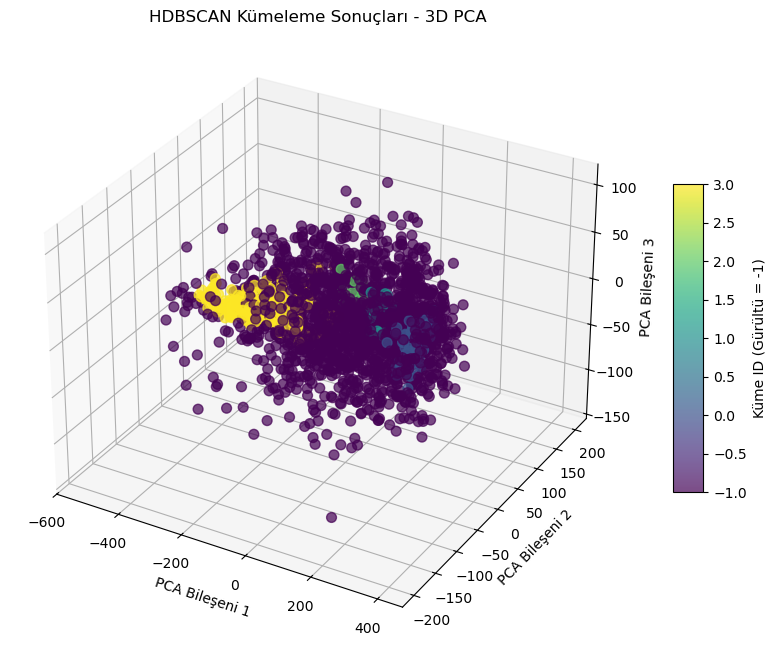

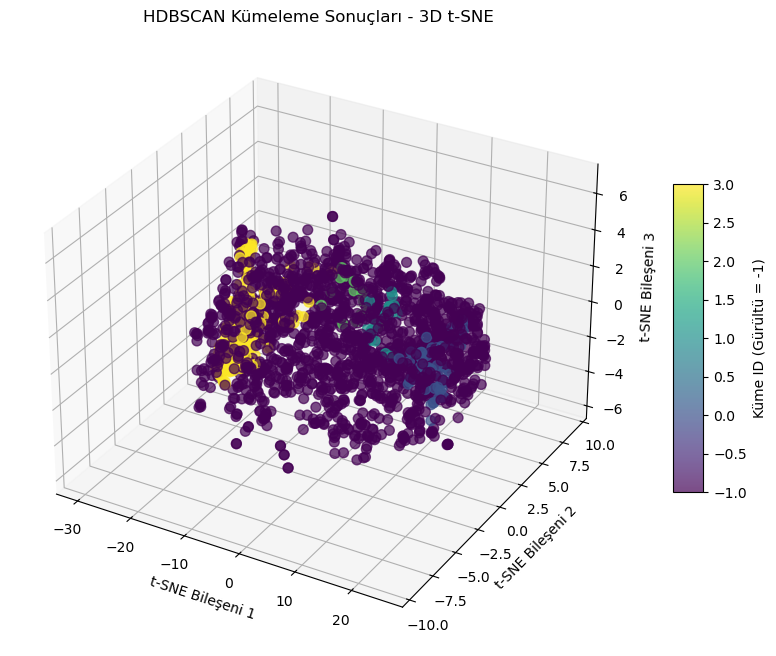

In [77]:
# --- Adƒ±m 1: HDBSCAN ile k√ºmeleme ---
# HDBSCAN algoritmasƒ±nƒ± belirli parametrelerle ba≈ülatƒ±yoruz:
# min_cluster_size = 15 ‚Üí bir k√ºmenin minimum √∂rnek sayƒ±sƒ±
# min_samples = 10 ‚Üí bir noktanƒ±n √ßekirdek nokta olabilmesi i√ßin gerekli minimum kom≈üu sayƒ±sƒ±
clusterer = hdbscan.HDBSCAN(min_cluster_size=15, min_samples=10)
clusters_hdbscan = clusterer.fit_predict(X)  # K√ºmeleme i≈ülemi

# G√ºr√ºlt√º = -1 olarak etiketlenir, bu y√ºzden toplam k√ºme sayƒ±sƒ±ndan 1 √ßƒ±karƒ±yoruz
print(f"HDBSCAN algoritmasƒ± {len(np.unique(clusters_hdbscan)) - 1} k√ºme buldu.")

# --- Adƒ±m 2: PCA ile 3D G√∂rselle≈ütirme ---
# PCA (Principal Component Analysis) ile veriyi 3 boyuta indiriyoruz
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

# 3D grafik olu≈üturma
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# PCA sonucu elde edilen 3 bile≈üeni kullanarak noktalarƒ± √ßiziyoruz
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=clusters_hdbscan, cmap='viridis', s=50, alpha=0.7)

ax.set_title('HDBSCAN K√ºmeleme Sonu√ßlarƒ± - 3D PCA')
ax.set_xlabel('PCA Bile≈üeni 1')
ax.set_ylabel('PCA Bile≈üeni 2')
ax.set_zlabel('PCA Bile≈üeni 3')

# Renk skalasƒ± ekleme (k√ºme ID'leri i√ßin)
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('K√ºme ID (G√ºr√ºlt√º = -1)')

plt.show()

# --- Adƒ±m 3: t-SNE ile 3D G√∂rselle≈ütirme ---
# t-SNE (t-Distributed Stochastic Neighbor Embedding) ile 3 boyutlu g√∂rselle≈ütirme
# Bu y√∂ntem √∂zellikle karma≈üƒ±k veri setlerinde daha net ayrƒ±mlar g√∂sterebilir
tsne = TSNE(n_components=3, random_state=0)
X_tsne = tsne.fit_transform(X)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
                     c=clusters_hdbscan, cmap='viridis', s=50, alpha=0.7)

ax.set_title('HDBSCAN K√ºmeleme Sonu√ßlarƒ± - 3D t-SNE')
ax.set_xlabel('t-SNE Bile≈üeni 1')
ax.set_ylabel('t-SNE Bile≈üeni 2')
ax.set_zlabel('t-SNE Bile≈üeni 3')

# Renk skalasƒ± ekleme
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('K√ºme ID (G√ºr√ºlt√º = -1)')

plt.show()

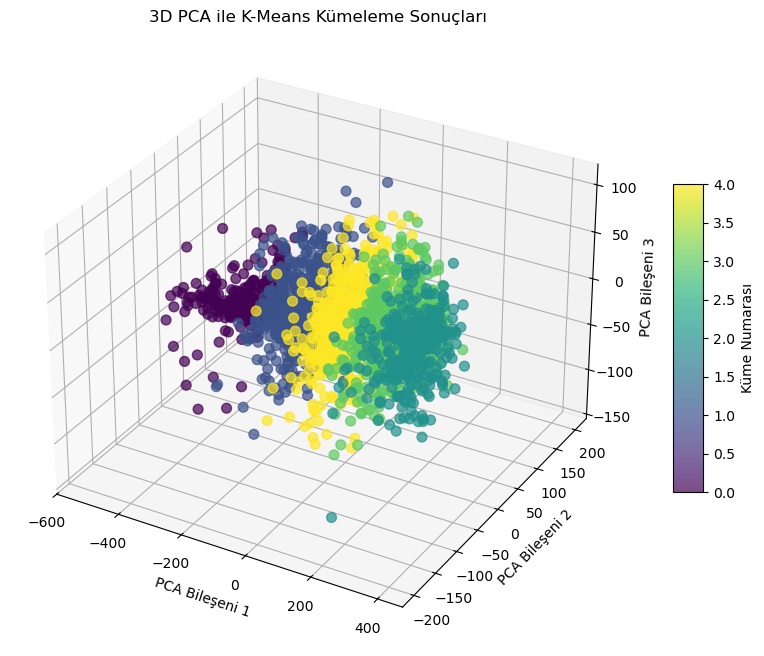

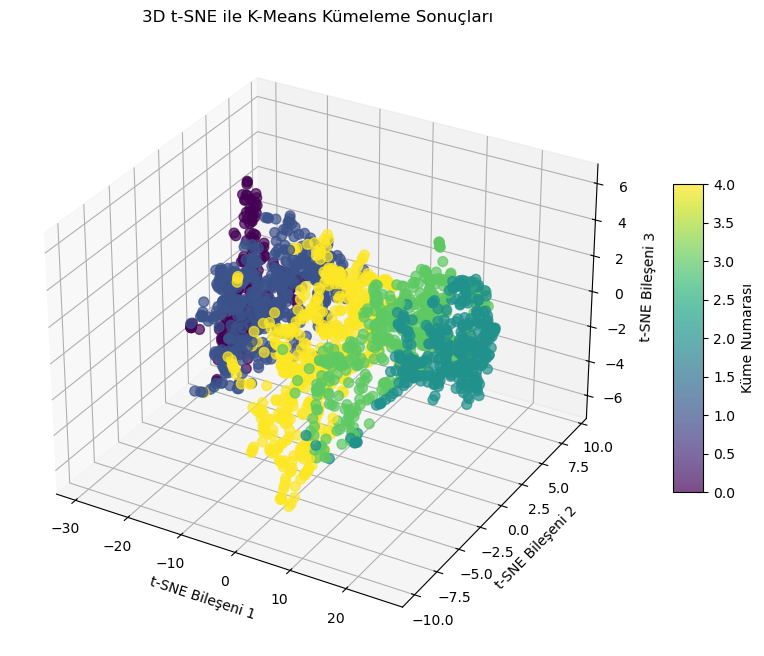

In [78]:
# --- 1. K-Means K√ºmeleme ---
n_clusters = 5  # Belirlemek istediƒüiniz k√ºme sayƒ±sƒ±
kmeans = KMeans(n_clusters=n_clusters, random_state=0)
clusters_kmeans = kmeans.fit_predict(X)  # K-Means ile k√ºmeleri bulma

# Veri ile etiketlerin uyumlu olduƒüunu kontrol et
assert len(clusters_kmeans) == len(X), "Hata: K√ºme etiketleri ile veri uzunluƒüu uyu≈ümuyor!"

# === 2. PCA ile 3D Boyut ƒ∞ndirgeme ve G√∂rselle≈ütirme ===
# PCA (Principal Component Analysis) ile 3 boyuta indiriyoruz
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# PCA sonucu noktalarƒ± k√ºmelere g√∂re renklendirerek √ßiziyoruz
scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2],
                     c=clusters_kmeans, cmap='viridis', s=50, alpha=0.7)

ax.set_title('3D PCA ile K-Means K√ºmeleme Sonu√ßlarƒ±')
ax.set_xlabel('PCA Bile≈üeni 1')
ax.set_ylabel('PCA Bile≈üeni 2')
ax.set_zlabel('PCA Bile≈üeni 3')

# Renk skalasƒ± ekleme (k√ºme numaralarƒ±nƒ± g√∂sterir)
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('K√ºme Numarasƒ±')

plt.show()

# === 3. t-SNE ile 3D Boyut ƒ∞ndirgeme ve G√∂rselle≈ütirme ===
# t-SNE (t-Distributed Stochastic Neighbor Embedding) ile 3 boyutlu indirgeme
# Perplexity deƒüeri, veri boyutuna uygun ≈üekilde ayarlanƒ±r
perplexity_value = min(30, len(X) - 1)
tsne = TSNE(n_components=3, random_state=0, perplexity=perplexity_value)

# √ñnce PCA ile indirgenmi≈ü veriyi t-SNE'ye veriyoruz (daha hƒ±zlƒ± ve kararlƒ± olur)
X_tsne = tsne.fit_transform(X_pca)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# t-SNE sonucu noktalarƒ± k√ºmelere g√∂re renklendirerek √ßiziyoruz
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2],
                     c=clusters_kmeans, cmap='viridis', s=50, alpha=0.7)

ax.set_title('3D t-SNE ile K-Means K√ºmeleme Sonu√ßlarƒ±')
ax.set_xlabel('t-SNE Bile≈üeni 1')
ax.set_ylabel('t-SNE Bile≈üeni 2')
ax.set_zlabel('t-SNE Bile≈üeni 3')

# Renk skalasƒ± ekleme
cbar = fig.colorbar(scatter, ax=ax, shrink=0.5, aspect=10)
cbar.set_label('K√ºme Numarasƒ±')

plt.show()

## 8. Son√º√ßlarƒ± Kaydet

In [81]:
import os
import json

# Ses dosyalarƒ±nƒ±n bulunduƒüu klas√∂r yolu (burayƒ± kendi klas√∂r√ºne g√∂re deƒüi≈ütir)
klasor_yolu = "C:/Users/somef/Downloads/audio"

# Klas√∂rdeki .wav dosyalarƒ±nƒ± bul ve listeye ekle
dosya_isimleri = [f for f in os.listdir(klasor_yolu) if f.endswith(".wav")]

print(f"{len(dosya_isimleri)} adet ses dosyasƒ± bulundu.")

# K√ºme etiketlerini (√∂rneƒüin clusters_hdbscan) burada kullan
kume_etiketleri = clusters_hdbscan  # Veya istediƒüin k√ºmeleme sonucu

# Dosya sayƒ±sƒ± ile k√ºme sayƒ±sƒ± e≈üle≈üiyor mu kontrol et
assert len(dosya_isimleri) == len(kume_etiketleri), "Dosya sayƒ±sƒ± ile k√ºme sayƒ±sƒ± uyu≈ümuyor!"

# Dosya adƒ± ve k√ºme etiketlerini e≈üle≈ütir
dosya_kume_map = {dosya_isimleri[i]: int(kume_etiketleri[i]) for i in range(len(dosya_isimleri))}

# Sonu√ßlarƒ± JSON dosyasƒ±na kaydet
with open("kume_ses_dosyalar.json", "w", encoding="utf-8") as f:
    json.dump(dosya_kume_map, f, indent=4, ensure_ascii=False)

print("‚úÖ K√ºmeleme sonu√ßlarƒ± 'kume_ses_dosyalar.json' dosyasƒ±na ba≈üarƒ±yla kaydedildi.")


1990 adet ses dosyasƒ± bulundu.
‚úÖ K√ºmeleme sonu√ßlarƒ± 'kume_ses_dosyalar.json' dosyasƒ±na ba≈üarƒ±yla kaydedildi.
